# Investigate a Relational Database 

## SQL for data analysis module

### Udacity - Programming for data science with R



In this project, SQL is used to explore a database related to movie rentals. SQL code is implemented to run SQL queries and answer interesting questions about the database. 

## Introduction

In this project, the Sakila DVD Rental databas is explored. The Sakila Database holds information about a company that rents movie DVDs. For this project, the mentioned database will querying to gain an understanding of the customer base, such as what the patterns in movie watching are across different customer groups, how they compare on payment earnings, and how the stores compare in their performance.

## Importing required libraries

In [1]:
import pandas as pd
import psycopg2
import sqlalchemy
import matplotlib.pyplot as plt
from IPython.display import Image
from sqlalchemy import create_engine
from Functions import PlottingResults
%matplotlib inline

## DB Entity Relationship (ER) Diagram

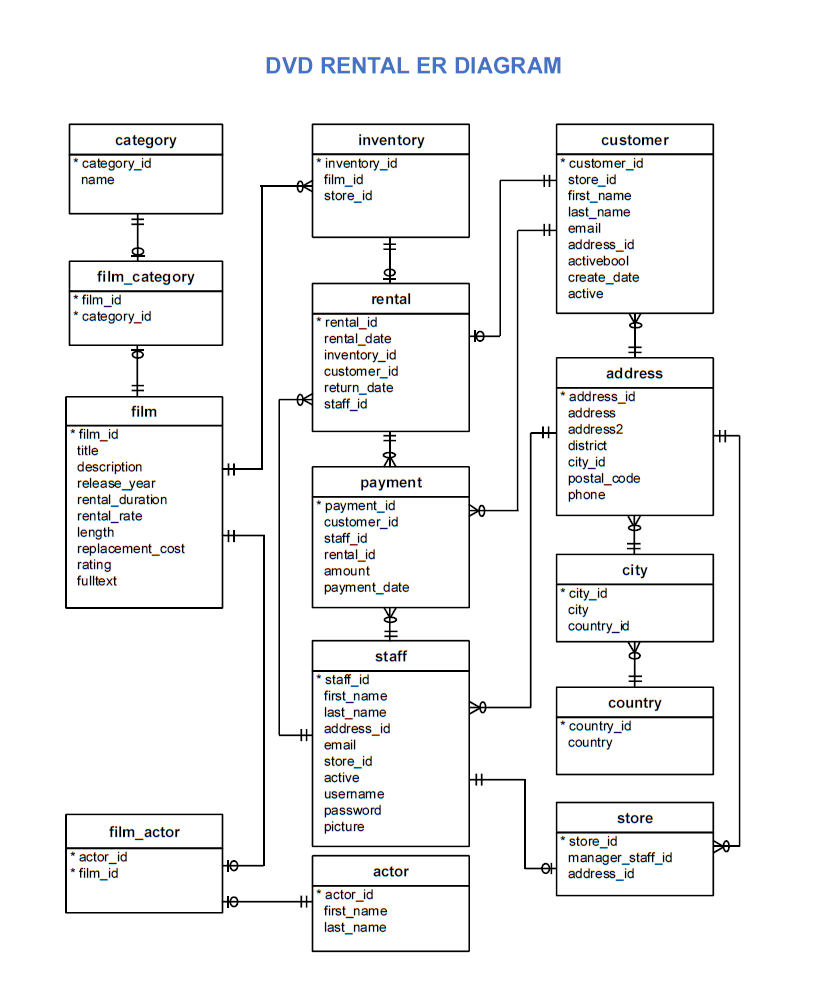

In [2]:
Image("images/dvd-rental-erd.png")

## Connecting with the dvdrental database

In [3]:
# Defining the postgres parameters for the db connection
post_address = 'localhost' 
post_port = 'xxxx'
post_username = 'postgres' 
post_password = 'xxxx' 
post_dbname = 'dvdrental'

# Creating the string for the postgres connection
postgres_str = ('postgresql://{username}:{password}@{ipaddress}:{port}/{dbname}'
                .format(username=post_username,
                 ipaddress=post_address,
                 password=post_password, 
                 port=post_port, 
                 dbname=post_dbname))

# Connecing to the specified database
cnx = create_engine(postgres_str)

## Question Set 1

### Question 1 - What are the rental categories preferences? 

We want to understand more about the movies that families are watching. The following categories are considered family movies: Animation, Children, Classics, Comedy, Family and Music. Create a query that lists each movie, the film category it is classified in, and the number of times it has been rented out.

In [4]:
#Query for question 1:

Query = pd.read_sql_query('''
SELECT film_title, 
       category_name,
       rental_count
FROM 
    (SELECT DISTINCT(a.title) film_title, 
            c.name category_name,
            COUNT(e.rental_id) OVER(PARTITION BY a.title ORDER by a.title) rental_count
    FROM film as a
    JOIN film_category as b
        ON a.film_id = b.film_id
    JOIN category as c
        ON c.category_id = b.category_id     
    JOIN inventory as d
        ON a.film_id = d.film_id
    JOIN rental as e
        ON d.inventory_id = e.inventory_id) as TempTable
WHERE category_name = 'Animation'
      OR category_name = 'Children'
      OR category_name = 'Classics'
      OR category_name = 'Comedy'
      OR category_name = 'Family'
      OR category_name = 'Music'
ORDER BY category_name, film_title;''', cnx)

Query.head(12)

,film_title,category_name,rental_count
0,Alter Victory,Animation,22
1,Anaconda Confessions,Animation,21
2,Bikini Borrowers,Animation,17
3,Blackout Private,Animation,27
4,Borrowers Bedazzled,Animation,22
5,Canyon Stock,Animation,19
6,Carol Texas,Animation,18
7,Champion Flatliners,Animation,13
8,Clash Freddy,Animation,25
9,Club Graffiti,Animation,19


#### Plotting and analyzing query results

The results obtained show that there exist more movies related to the Family category, while, on average, movies from the Animation category are the most rented. It is interesting to note that, on average, movies related to the Classics category are more rented than categories that show a bigger presence, such as the Family, Children and Comedy categories.

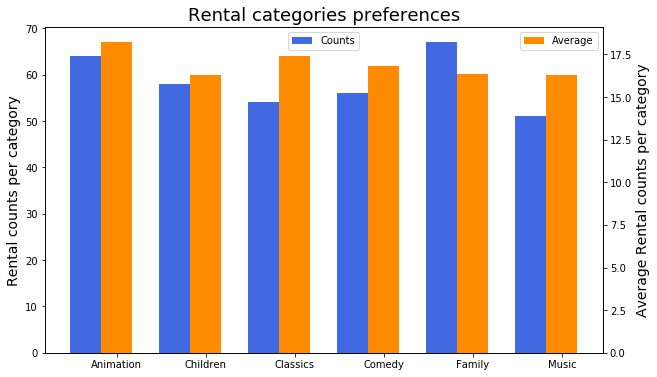

In [5]:
labels = Query.category_name.unique().tolist()
vals1 = Query.groupby(['category_name']).count().rental_count.tolist()
vals2 = Query.groupby(['category_name']).mean().rental_count.tolist()
titles = ['Rental categories preferences', 'Rental counts per category', 'Average Rental counts per category']
legends = ['Counts', 'Average']
PlottingResults(labels,titles,vals1,vals2,ax2p=1,legends=legends)

### Question 2 - Which are the rental times per category?

Provide a table with the movie titles and divide them into 4 levels (first_quarter, second_quarter, third_quarter, and final_quarter) based on the quartiles (25%, 50%, 75%) of the rental duration for movies across all categories? Make sure to also indicate the category that these family-friendly movies fall into.

In [6]:
# Query for question 2:

Query = pd.read_sql_query('''
SELECT title, 
       category_name,
       rental_duration,
       NTILE(4) OVER (PARTITION BY rental_duration) AS standard_quartile
FROM 
    (SELECT a.title title, 
            c.name category_name,
            a.rental_duration rental_duration
    FROM film as a
    JOIN film_category as b
        ON a.film_id = b.film_id
    JOIN category as c
        ON c.category_id = b.category_id) as TempTable
WHERE category_name = 'Animation'
      OR category_name = 'Children'
      OR category_name = 'Classics'
      OR category_name = 'Comedy'
      OR category_name = 'Family'
      OR category_name = 'Music'
ORDER BY rental_duration;''', cnx)

Query.head(10)

,title,category_name,rental_duration,standard_quartile
0,Sweethearts Suspects,Children,3,1
1,Go Purple,Music,3,1
2,Bilko Anonymous,Family,3,1
3,Wait Cider,Animation,3,1
4,Daughter Madigan,Children,3,1
5,Turn Star,Animation,3,1
6,Rush Goodfellas,Family,3,1
7,King Evolution,Family,3,1
8,Tracy Cider,Animation,3,1
9,Wisdom Worker,Comedy,3,1


#### Plotting and analyzing query results

It can be seen that the rental times per category are very similar. It can be observed that the minimum and maximum rental times are the same for all categories. This is almost the case for the average rental time, which is not too different among all categories.


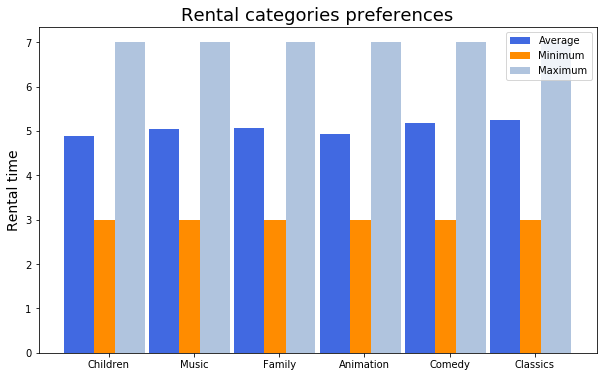

In [7]:
labels = Query.category_name.unique().tolist()
vals1 = Query.groupby(['category_name']).mean().rental_duration.tolist()
vals2 = Query.groupby(['category_name']).min().rental_duration.tolist()
vals3 = Query.groupby(['category_name']).max().rental_duration.tolist()
titles = ['Rental categories preferences', 'Rental time']
legends = ['Average', 'Minimum', 'Maximum']
PlottingResults(labels,titles,vals1,vals2,vals3,legends=legends)

### Question 3 - What are the rental time preferences?

Provide a table with the family-friendly film category, each of the quartiles, and the corresponding count of movies within each combination of film category for each corresponding rental duration category. 

In [8]:
# Query for question 3:

Query = pd.read_sql_query('''
SELECT category_name,
       standard_quartile,
       COUNT(*) count
FROM 
    (SELECT title, 
            category_name,
            rental_duration,
            NTILE(4) OVER (ORDER BY rental_duration) AS standard_quartile
    FROM 
        (SELECT a.title title, 
                c.name category_name,
                a.rental_duration rental_duration
        FROM film as a
        JOIN film_category as b
            ON a.film_id = b.film_id
        JOIN category as c
            ON c.category_id = b.category_id) as TempTable
    WHERE category_name = 'Animation'
        OR category_name = 'Children'
        OR category_name = 'Classics'
        OR category_name = 'Comedy'
        OR category_name = 'Family'
        OR category_name = 'Music'
    ORDER BY rental_duration) as TempTable2
GROUP BY category_name, standard_quartile
ORDER BY category_name, standard_quartile;''', cnx)

Query.head(10)

,category_name,standard_quartile,count
0,Animation,1,22
1,Animation,2,12
2,Animation,3,15
3,Animation,4,17
4,Children,1,14
5,Children,2,18
6,Children,3,14
7,Children,4,14
8,Classics,1,14
9,Classics,2,14


#### Plotting and analyzing query results

The figure presents the most common quartile in which can be classified movies accordingly with their rental times and the number of movies that exist, on average,  in each of the quartiles, for each category of interest. It can be concluded that most movies fell into the last quartile and that the amount of movies in each quartile is different for all categories. 


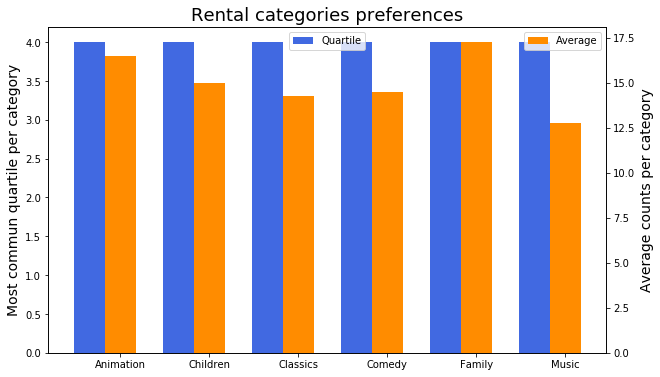

In [9]:
labels = Query.category_name.unique().tolist()
vals1 = Query.groupby(['category_name']).standard_quartile.agg(lambda x:x.value_counts().index[0]).tolist()
vals2 = Query.groupby(['category_name']).mean()['count'].tolist()
titles = ['Rental categories preferences', 'Most commun quartile per category', 'Average counts per category']
legends = ['Quartile', 'Average']
PlottingResults(labels,titles,vals1,vals2,ax2p=1,legends=legends)

## Question Set 2

### Question 1 - What are the number of rental per store?

Write a query that returns the store ID for the store, the year and month and the number of rental orders each store has fulfilled for that month. Your table should include a column for each of the following: year, month, store ID and count of rental orders fulfilled during that month. 

In [10]:
# Query for question 1:

Query = pd.read_sql_query('''
SELECT  DATE_PART('month', a.rental_date) Rental_month,
        DATE_PART('year', a.rental_date) Rental_year,
        c.store_id store_ID,
        COUNT(*) Count_rentals
FROM rental as a
JOIN staff as b
    ON a.staff_id = b.staff_id
JOIN store as c
    ON b.store_id = c.store_id
GROUP BY c.store_id, Rental_month, Rental_year
ORDER BY Count_rentals DESC;''', cnx)

Query.head(10)

,rental_month,rental_year,store_id,count_rentals
0,7.0,2005.0,2,3367
1,7.0,2005.0,1,3342
2,8.0,2005.0,1,2892
3,8.0,2005.0,2,2794
4,6.0,2005.0,1,1163
5,6.0,2005.0,2,1148
6,5.0,2005.0,2,598
7,5.0,2005.0,1,558
8,2.0,2006.0,2,97
9,2.0,2006.0,1,85


#### Plotting and analyzing query results

This query let us know the difference in rentals for both stores analyzed. In the next figure can be observed that, even when the number of rentals is different, it can be said that is almost the same for both stores. The data is missing several important months for the analysis, which limit our understanding of the pattern of rentals in both stores. 

C:\Users\alfde\Anaconda3\envs\DeepLearning\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
C:\Users\alfde\Anaconda3\envs\DeepLearning\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\alfde\Anaconda3\envs\DeepLearning\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


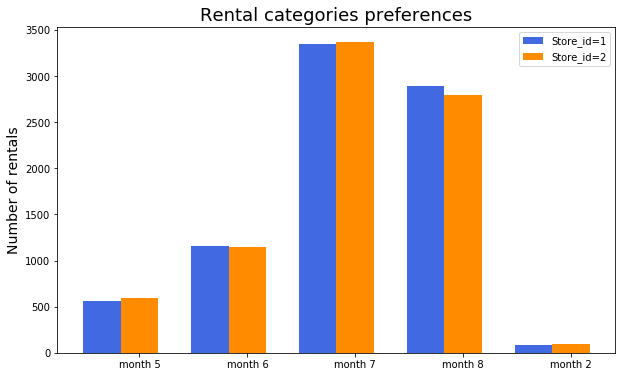

In [11]:
labels = ['month ' + str(int(n)) for n in Query.sort_values(by=['rental_year', 'rental_month'])[Query.store_id == 1].
 rental_month.unique().tolist()]
vals1 = Query.sort_values(by=['rental_year', 'rental_month'])[Query.store_id == 1].count_rentals.tolist()
vals2 = Query.sort_values(by=['rental_year', 'rental_month'])[Query.store_id == 2].count_rentals.tolist()
titles = ['Rental categories preferences', 'Number of rentals']
legends = ['Store_id=1', 'Store_id=2']
PlottingResults(labels,titles,vals1,vals2,legends=legends)

### Question 2 - What are the preferences for customers that spend more?

Can you write a query to capture the customer name, month and year of payment, and total payment amount for each month by the top 10 paying customers?

In [12]:
# Query for question 2:

Query = pd.read_sql_query('''
WITH bas AS 
    (SELECT a.customer_id,
            SUM(a.amount) AS total_amount
    FROM payment a
    JOIN customer b
        ON a.customer_id = b.customer_id
    GROUP BY 1
    ORDER BY 2 DESC
    LIMIT 10)

SELECT bas2.fecha fecha,
       bas2.full_name full_name,
       bas2.pay_countpermonth,
       bas2.pay_amount pay_amount
FROM bas
JOIN
    (SELECT DISTINCT(pay_year || '-' || pay_month) as fecha,
            customer_id,
            full_name,
            COUNT(*) pay_countpermonth,
            SUM(pay_amount) AS pay_amount
     FROM 
         (SELECT DATE_PART('year', a.payment_date) pay_year,
                 DATE_PART('month', a.payment_date) pay_month,
                 b.first_name || ' ' || b.last_name full_name,
                 a.customer_id,
                 a.amount pay_amount
         FROM payment as a
         JOIN customer as b
             ON a.customer_id = b.customer_id) as tab1
          GROUP BY 1, 2,3) AS bas2
    ON bas.customer_id = bas2.customer_id
ORDER BY full_name, fecha;''', cnx)

Query.head(10)

,fecha,full_name,pay_countpermonth,pay_amount
0,2007-2,Ana Bradley,4,19.96
1,2007-3,Ana Bradley,16,71.84
2,2007-4,Ana Bradley,12,72.88
3,2007-5,Ana Bradley,1,2.99
4,2007-2,Clara Shaw,6,22.94
5,2007-3,Clara Shaw,16,72.84
6,2007-4,Clara Shaw,18,93.82
7,2007-2,Curtis Irby,6,22.94
8,2007-3,Curtis Irby,17,86.83
9,2007-4,Curtis Irby,14,54.86


#### Plotting and analyzing query results

The figure shows the payments for the 10 costumers that spend more renting movies. To be more specific, it shows the maximum amount paid and the maximum number of payments, monthly, for each of the mentioned customers. There is not a clear relationship among those features, considering all costumers.

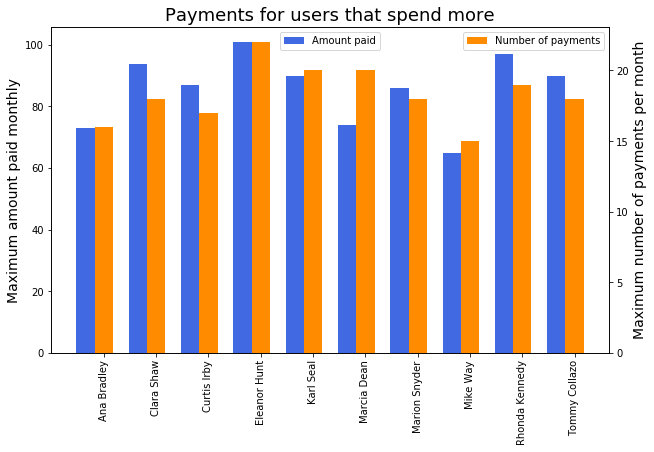

In [13]:
labels = Query.full_name.unique().tolist()
vals1 = Query.groupby(['full_name']).max().pay_amount.tolist()
vals2 = Query.groupby(['full_name']).max().pay_countpermonth.tolist()
titles = ['Payments for users that spend more', 'Maximum amount paid monthly', 'Maximum number of payments per month']
legends = ['Amount paid', 'Number of payments']
PlottingResults(labels,titles,vals1,vals2,ax2p=1,legends=legends, rot=90)

### Question 3 - What are the differences for customers that spend more?

Query to find out differences across monthly payments during 2007, for the 10 costumers that pay more every month

In [14]:
# Query for question 3:

Query = pd.read_sql_query('''
WITH temp1 AS
    (WITH bas AS 
        (SELECT a.customer_id,
                SUM(a.amount) AS total_amount
        FROM payment a
        JOIN customer b
            ON a.customer_id = b.customer_id
        GROUP BY 1
        ORDER BY 2 DESC
        LIMIT 10)

    SELECT ROW_NUMBER() OVER(ORDER BY bas2.full_name) AS RowNumber,
           bas2.fecha fecha,
           bas2.full_name full_name,
           bas2.pay_countpermonth,
           bas2.pay_amount pay_amount
    FROM bas
    JOIN
        (SELECT DISTINCT(pay_year || '-' || pay_month) as fecha,
                customer_id,
                full_name,
                COUNT(*) pay_countpermonth,
                SUM(pay_amount) AS pay_amount
        FROM 
            (SELECT DATE_PART('year', a.payment_date) pay_year,
                    DATE_PART('month', a.payment_date) pay_month,
                    b.first_name || ' ' || b.last_name full_name,
                    a.customer_id,
                    a.amount pay_amount
            FROM payment as a
            JOIN customer as b
                ON a.customer_id = b.customer_id) as tab1
            GROUP BY 1, 2,3
            ORDER BY full_name, fecha) AS bas2
        ON bas.customer_id = bas2.customer_id)

SELECT fecha,
       full_name,
       pay_countpermonth,
       monthly_diff
FROM
    (SELECT a.fecha fecha,
            a.full_name full_name,
            a.pay_countpermonth pay_countpermonth,
            a.pay_amount amount,
            ABS(a.pay_amount - b.pay_amount) monthly_diff
    FROM temp1 a
    LEFT JOIN temp1 b 
        ON a.RowNumber = b.RowNumber+1) as temptable3
WHERE fecha NOT IN ('2007-2')
ORDER BY full_name, fecha;''', cnx)

Query.head(10)

,fecha,full_name,pay_countpermonth,monthly_diff
0,2007-3,Ana Bradley,16,51.88
1,2007-4,Ana Bradley,12,1.04
2,2007-5,Ana Bradley,1,69.89
3,2007-3,Clara Shaw,16,49.90
4,2007-4,Clara Shaw,18,20.98
5,2007-3,Curtis Irby,17,63.89
6,2007-4,Curtis Irby,14,31.97
7,2007-5,Curtis Irby,1,51.87
8,2007-3,Eleanor Hunt,18,64.87
9,2007-4,Eleanor Hunt,22,12.96


#### Plotting and analyzing query results

The figure shows payments for the 10 costumers that spend more renting movies, focused on the difference between monthly payments. The figure shows the maximum difference between monthly payments and the maximum number of payments by month, for each of the customers. It can be observed that the variance among monthly payments is considerable. This means that costumers presents different monthly payment patterns. 

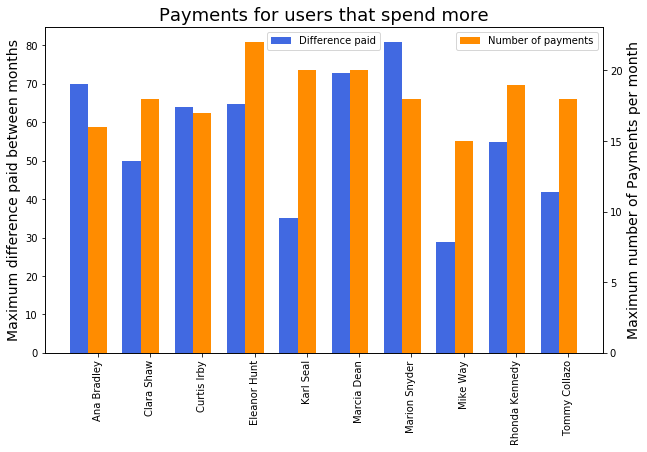

In [15]:
labels = Query.full_name.unique().tolist()
vals1 = Query.groupby(['full_name']).max().monthly_diff.tolist()
vals2 = Query.groupby(['full_name']).max().pay_countpermonth.tolist()
titles = ['Payments for users that spend more', 'Maximum difference paid between months', 'Maximum number of Payments per month']
legends = ['Difference paid', 'Number of payments']
PlottingResults(labels,titles,vals1,vals2,ax2p=1,legends=legends, rot=90)

#### Identifying the customer name who paid the most difference in terms of payments.

In [16]:
Query = pd.read_sql_query('''
WITH temp1 AS
    (WITH bas AS 
        (SELECT a.customer_id,
                SUM(a.amount) AS total_amount
        FROM payment a
        JOIN customer b
            ON a.customer_id = b.customer_id
        GROUP BY 1
        ORDER BY 2 DESC
        LIMIT 10)

    SELECT ROW_NUMBER() OVER(ORDER BY bas2.full_name) AS RowNumber,
           bas2.fecha fecha,
           bas2.full_name full_name,
           bas2.pay_countpermonth,
           bas2.pay_amount pay_amount
    FROM bas
    JOIN
        (SELECT DISTINCT(pay_year || '-' || pay_month) as fecha,
                customer_id,
                full_name,
                COUNT(*) pay_countpermonth,
                SUM(pay_amount) AS pay_amount
        FROM 
            (SELECT DATE_PART('year', a.payment_date) pay_year,
                    DATE_PART('month', a.payment_date) pay_month,
                    b.first_name || ' ' || b.last_name full_name,
                    a.customer_id,
                    a.amount pay_amount
            FROM payment as a
            JOIN customer as b
                ON a.customer_id = b.customer_id) as tab1
            GROUP BY 1, 2,3
            ORDER BY full_name, fecha) AS bas2
        ON bas.customer_id = bas2.customer_id)

SELECT fecha,
       full_name,
       pay_countpermonth,
       monthly_diff
FROM
    (SELECT a.fecha fecha,
            a.full_name full_name,
            a.pay_countpermonth pay_countpermonth,
            a.pay_amount amount,
            ABS(a.pay_amount - b.pay_amount) monthly_diff
    FROM temp1 a
    LEFT JOIN temp1 b 
        ON a.RowNumber = b.RowNumber+1) as temptable3
WHERE fecha NOT IN ('2007-2')
ORDER BY monthly_diff DESC
LIMIT 1;''', cnx)

Query.head(1)

,fecha,full_name,pay_countpermonth,monthly_diff
0,2007-5,Marion Snyder,1,80.83


In [17]:
#Fin